<a href="https://colab.research.google.com/github/kridtapon/Coppock-Accumulation-Strategy/blob/main/Coppock_Accumulation_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [3]:
pip install --upgrade yfinance

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Accumulation/Distribution Line (A/D)
def calculate_ad_line(df):
    """
    Calculate Accumulation/Distribution Line (A/D).
    """
    ad_line = [0]  # Initial A/D Line value
    for i in range(1, len(df)):
        money_flow_multiplier = ((df['Close'][i] - df['Low'][i]) - (df['High'][i] - df['Close'][i])) / (df['High'][i] - df['Low'][i])
        money_flow_volume = money_flow_multiplier * df['Volume'][i]
        ad_line.append(ad_line[-1] + money_flow_volume)
    return pd.Series(ad_line, index=df.index)

# Function to calculate Coppock Curve
def calculate_coppock_curve(df, period_short=14, period_long=11, period_smooth=10):
    """
    Calculate Coppock Curve.
    """
    # Rate of Change for two different periods
    roc_short = df['Close'].pct_change(periods=period_short) * 100
    roc_long = df['Close'].pct_change(periods=period_long) * 100

    # Coppock Curve calculation (Sum of ROC and smoothing it)
    coppock_curve = (roc_short + roc_long).rolling(window=period_smooth).sum()

    return coppock_curve

# Define the stock symbol and time period
symbol = 'META'  # SPY is the symbol for the S&P 500 ETF
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Accumulation/Distribution Line (A/D)
df['A/D Line'] = calculate_ad_line(df)

# Calculate Coppock Curve
df['Coppock Curve'] = calculate_coppock_curve(df)

# Define Entry and Exit signals based on A/D Line and Coppock Curve
df['Entry'] = (df['A/D Line'] > df['A/D Line'].shift(1)) & (df['Coppock Curve'] > 0)
df['Exit'] = (df['A/D Line'] < df['A/D Line'].shift(1)) & (df['Coppock Curve'] < 0)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-a8ce41a8a9cb>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  money_flow_multiplier = ((df['Close'][i] - df['Low'][i]) - (df['High'][i] - df['Close'][i])) / (df['High'][i] - df['Low'][i])
<ipython-input-5-a8ce41a8a9cb>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  money_flow_volume = money_flow_multiplier * df['Volume'][i]
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           324122.240021
Total Return [%]                        224.12224
Benchmark Return [%]                   180.172898
Max Gross Exposure [%]                      100.0
Total Fees Paid                       9952.459506
Max Drawdown [%]                          38.8291
Max Drawdown Duration                       612.0
Total Trades                                   25
Total Closed Trades                            25
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 44.0
Best Trade [%]                           65.65294
Worst Trade [%]                        -12.005361
Avg Winning Trade [%]                   20.911054
Avg Losing Trade [%]                    -4.867495


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate Accumulation/Distribution Line (A/D)
def calculate_ad_line(df):
    ad_line = [0]
    for i in range(1, len(df)):
        money_flow_multiplier = ((df['Close'][i] - df['Low'][i]) - (df['High'][i] - df['Close'][i])) / (df['High'][i] - df['Low'][i])
        money_flow_volume = money_flow_multiplier * df['Volume'][i]
        ad_line.append(ad_line[-1] + money_flow_volume)
    return pd.Series(ad_line, index=df.index)

# Function to calculate Coppock Curve
def calculate_coppock_curve(df, period_short, period_long, period_smooth):
    roc_short = df['Close'].pct_change(periods=period_short) * 100
    roc_long = df['Close'].pct_change(periods=period_long) * 100
    coppock_curve = (roc_short + roc_long).rolling(window=period_smooth).sum()
    return coppock_curve

# Download stock data
symbol = 'SPY'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges for optimization
period_short_range = range(10, 21, 2)
period_long_range = range(5, 18, 2)
period_smooth_range = range(5, 16, 2)
ad_shift_range = range(1, 11)  # Shift A/D Line by 1 to 10 days

best_performance = -np.inf
best_params = None

# Grid search over all parameter combinations
for period_short, period_long, period_smooth, ad_shift in itertools.product(period_short_range, period_long_range, period_smooth_range, ad_shift_range):

    df['A/D Line'] = calculate_ad_line(df)
    df['Coppock Curve'] = calculate_coppock_curve(df, period_short, period_long, period_smooth)

    # Apply A/D shift
    df['Entry'] = (df['A/D Line'] > df['A/D Line'].shift(ad_shift)) & (df['Coppock Curve'] > 0)
    df['Exit'] = (df['A/D Line'] < df['A/D Line'].shift(ad_shift)) & (df['Coppock Curve'] < 0)

    # Filter data for the test period
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Backtest
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['Entry'],
        exits=df_test['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Evaluate performance
    total_return = portfolio.total_return()

    # Check if this is the best-performing strategy
    if total_return > best_performance:
        best_performance = total_return
        best_params = (period_short, period_long, period_smooth, ad_shift)

# Display best parameters
print(f"Best Parameters: period_short={best_params[0]}, period_long={best_params[1]}, period_smooth={best_params[2]}, ad_shift={best_params[3]}")
print(f"Best Performance (Total Return): {best_performance}")

# Calculate Accumulation/Distribution Line (A/D)
df['A/D Line'] = calculate_ad_line(df)

# Calculate Coppock Curve
df['Coppock Curve'] = calculate_coppock_curve(df, period_short=best_params[0], period_long=best_params[1], period_smooth=best_params[2])

# Define Entry and Exit signals based on A/D Line and Coppock Curve
df['Entry'] = (df['A/D Line'] > df['A/D Line'].shift(best_params[3])) & (df['Coppock Curve'] > 0)
df['Exit'] = (df['A/D Line'] < df['A/D Line'].shift(best_params[3])) & (df['Coppock Curve'] < 0)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-8-4d138baca73b>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-8-4d138baca73b>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-8-4d138baca73b>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-8-4d138baca73b>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future 

Best Parameters: period_short=10, period_long=7, period_smooth=5, ad_shift=8
Best Performance (Total Return): 1.0453047511234166
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           204530.475112
Total Return [%]                       104.530475
Benchmark Return [%]                    94.584983
Max Gross Exposure [%]                      100.0
Total Fees Paid                       8531.257162
Max Drawdown [%]                        14.680031
Max Drawdown Duration                       266.0
Total Trades                                   29
Total Closed Trades                            29
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            65.517241
Best Trade [%]                          26.387276
Worst Trade [%]      

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



In [10]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,194584.983273
Total Return [%],94.584983
Benchmark Return [%],94.584983
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],33.717249


[*********************100%***********************]  1 of 1 completed
<ipython-input-12-78463634b167>:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-78463634b167>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



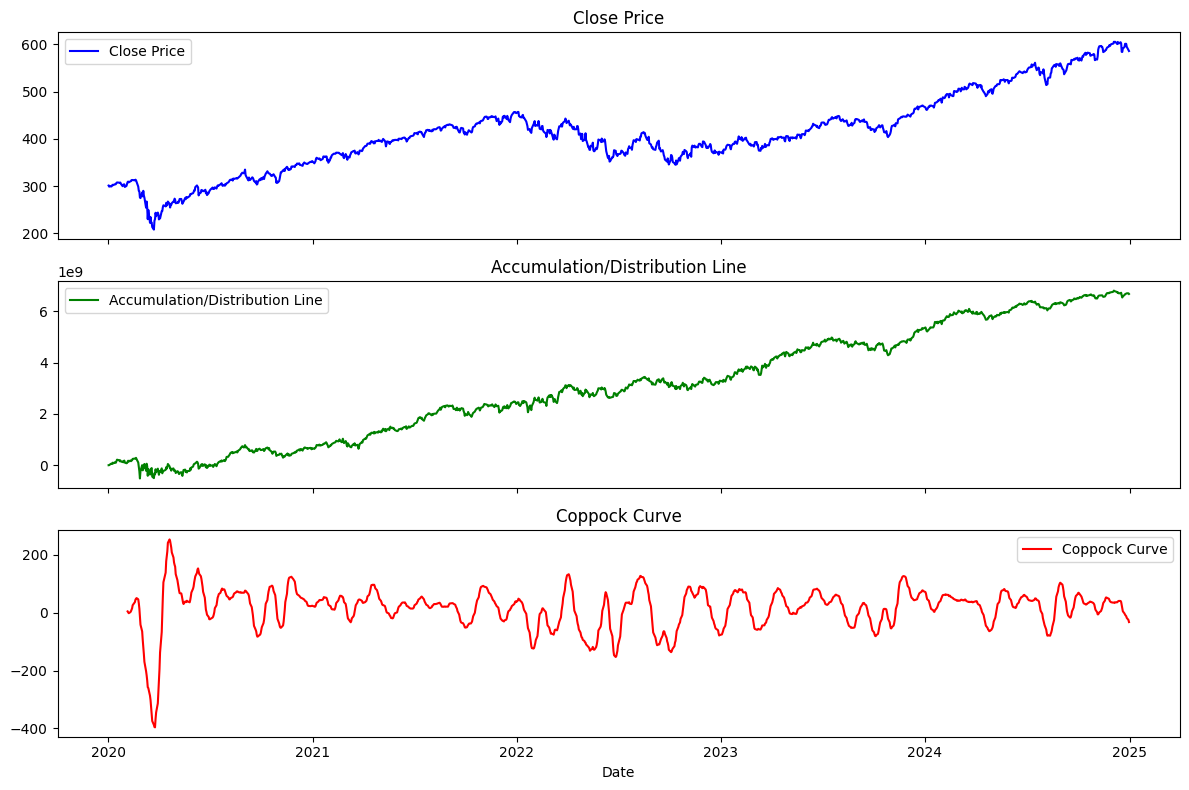

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def calculate_ad_line(df):
    ad_line = [0]
    for i in range(1, len(df)):
        money_flow_multiplier = ((df['Close'][i] - df['Low'][i]) - (df['High'][i] - df['Close'][i])) / (df['High'][i] - df['Low'][i])
        money_flow_volume = money_flow_multiplier * df['Volume'][i]
        ad_line.append(ad_line[-1] + money_flow_volume)
    return pd.Series(ad_line, index=df.index)

def calculate_coppock_curve(df, period_short=11, period_long=14, period_smooth=10):
    roc_short = df['Close'].pct_change(periods=period_short) * 100
    roc_long = df['Close'].pct_change(periods=period_long) * 100
    coppock_curve = (roc_short + roc_long).rolling(window=period_smooth).sum()
    return coppock_curve

# Download stock data
symbol = 'SPY'
start_date = '2020-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Compute indicators
df['A/D Line'] = calculate_ad_line(df)
df['Coppock Curve'] = calculate_coppock_curve(df)

# Plot the indicators with Close price
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(df.index, df['Close'], label='Close Price', color='blue')
ax[0].set_title('Close Price')
ax[0].legend()

ax[1].plot(df.index, df['A/D Line'], label='Accumulation/Distribution Line', color='green')
ax[1].set_title('Accumulation/Distribution Line')
ax[1].legend()

ax[2].plot(df.index, df['Coppock Curve'], label='Coppock Curve', color='red')
ax[2].set_title('Coppock Curve')
ax[2].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [9]:
from scipy.stats import linregress

# Calculate Alpha, Beta, and Correlation with a Buy and Hold (B&H) strategy
portfolio_returns = portfolio.returns()
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
df_holding = df['Close']
benchmark = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
benchmark_returns = benchmark.returns()

# Ensure returns are aligned
portfolio_returns, benchmark_returns = portfolio_returns.align(benchmark_returns, join='inner')

# Calculate Beta and alpha using linear regression
slope, intercept, r_value, _, _ = linregress(benchmark_returns, portfolio_returns)
beta = slope
alpha = intercept

# Calculate Correlation
correlation = portfolio_returns.corr(benchmark_returns)

# Display results
print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Correlation: {correlation:.4f}")

Alpha: 0.0004
Beta: 0.3524
Correlation: 0.5923
